# Model Comparison in The Domain of Brain Tumor Image Classification  
For our final project for Spring 2025, CS 4644 - Deep Learning, we analyze and compare the results from three unique models:  
1. 3D CNN - Turning 2D images into 3D datapoints to reconstruct a full brain image.  
2. ResNet18 - Applying transfer learning by taking a pretrained ResNet-18 model (trained on ImageNet) and adapting it to MRI scans through the fine-tuning of a final fully connected layer.  
3. Inception - Applying transfer learning in the same way as ResNet, but for another popular and successful model.  
  
The following code allows the reader to experiment with these 3 models and observe their results.

# Step 0: Get necessary imports, set global variables, and setup dataset

In [1]:
# Basic imports
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
from PIL import Image
import matplotlib.pyplot as plt

from src import (
    get_optimizer,
    Trainer,
)
from src.models import (
    CNN_3D,
    MyResNet,
    MyInception
)
from data.data_transforms import (
    get_fundamental_transforms,
    get_fundamental_normalization_transforms,
    get_fundamental_augmentation_transforms,
    get_all_transforms,
)
from utils.confusion_matrix import (
    generate_confusion_data,
    generate_confusion_matrix,
    plot_confusion_matrix,
    get_pred_images_for_target,
    generate_and_plot_confusion_matrix,
)
from utils.utils import save_trained_model_weights
from utils.dataset_utils import prepare_dataset

#Folder paths
raw_data_path = "../data/raw/"
data_path = "../data/processed/"
model_path = "../src/models/"
results_path = "../results/"

# Global Variables
batch_size = 32
num_classes = 3 # Output classes: Pituitary, Meningioma, and Glioma Tumor
n_slices = 1 # TODO for 3D CNN: Change this if we find a pattern in the dataset for determining multiple images go to same patient

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Download the dataset, preprocess it, and compute statistics

In [2]:
dataset_mean, dataset_std = prepare_dataset(
    raw_data_path=raw_data_path,
    pickle_path= os.path.join(raw_data_path, "brain_tumor_mri/new_dataset/training_data.pickle"),
    processed_data_path=data_path,
    n_slices=n_slices, # TODO: figure out how many images in a row make up a 3d datapoint
)

[Info] Kaggle API token found.
[INFO] Raw data already exists. Skipping Kaggle download.
[INFO] Processed data directory already exists. Skipping conversion.
[INFO] Loading cached dataset mean and std...


# Step 1: Test 3D Convolutional Nerual Network

In [3]:
inp_size = (n_slices, 512, 512)

In [ ]:
model_cnn = CNN_3D(inp_size, num_classes=num_classes)

cnn_optimizer_config = {"optimizer_type": "adam", "lr": 1e-4, "weight_decay": 1e-8} # Tune these
cnn_optimizer = get_optimizer(model_cnn, cnn_optimizer_config)

cnn_trainer = Trainer(
    data_dir=data_path,
    model=model_cnn,
    optimizer=cnn_optimizer,
    model_dir=os.path.join(model_path, "CNN_3D"),
    train_data_transforms=get_all_transforms(tuple((inp_size[1], inp_size[2])), [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        tuple((inp_size[1], inp_size[2])), [dataset_mean], [dataset_std]
    ),
    batch_size=batch_size,
    load_from_disk=False,
    cuda=torch.cuda.is_available(),
    n_slices=n_slices,
)

In [ ]:
%%time
cnn_trainer.run_training_loop(num_epochs=20)

Minibatch:1 Train Loss:0.0335 Val Loss: 0.0335 Train Accuracy: 0.5000 Validation Accuracy: 0.5000
Minibatch:2 Train Loss:0.1369 Val Loss: 0.1369 Train Accuracy: 0.3750 Validation Accuracy: 0.3750
Minibatch:3 Train Loss:0.2408 Val Loss: 0.2408 Train Accuracy: 0.4062 Validation Accuracy: 0.4062
Minibatch:4 Train Loss:0.0991 Val Loss: 0.0991 Train Accuracy: 0.5625 Validation Accuracy: 0.5625
Minibatch:5 Train Loss:0.1170 Val Loss: 0.1170 Train Accuracy: 0.2188 Validation Accuracy: 0.2188
Minibatch:6 Train Loss:0.0646 Val Loss: 0.0646 Train Accuracy: 0.2812 Validation Accuracy: 0.2812
Minibatch:7 Train Loss:0.0460 Val Loss: 0.0460 Train Accuracy: 0.1250 Validation Accuracy: 0.1250
Minibatch:8 Train Loss:0.0336 Val Loss: 0.0336 Train Accuracy: 0.2812 Validation Accuracy: 0.2812
Minibatch:9 Train Loss:0.0328 Val Loss: 0.0328 Train Accuracy: 0.5312 Validation Accuracy: 0.5312
Minibatch:10 Train Loss:0.0329 Val Loss: 0.0329 Train Accuracy: 0.5938 Validation Accuracy: 0.5938
Minibatch:11 Train 

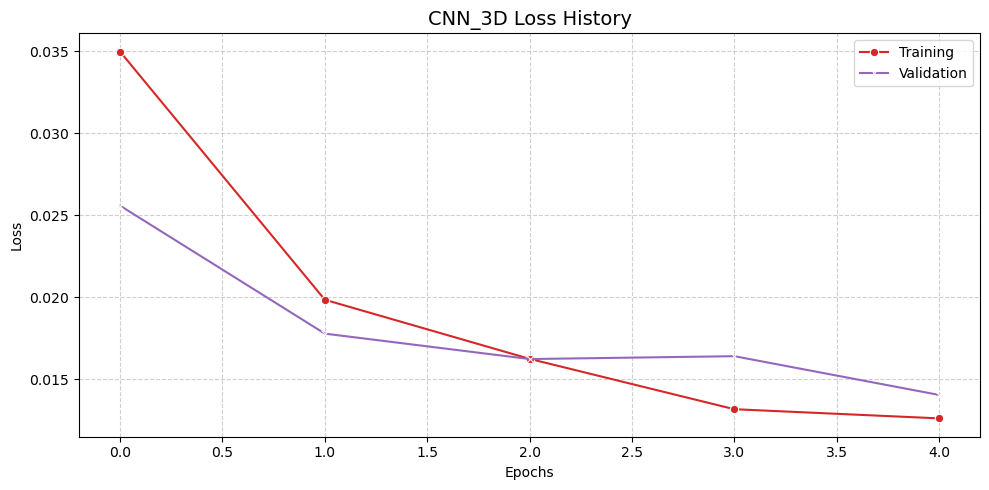

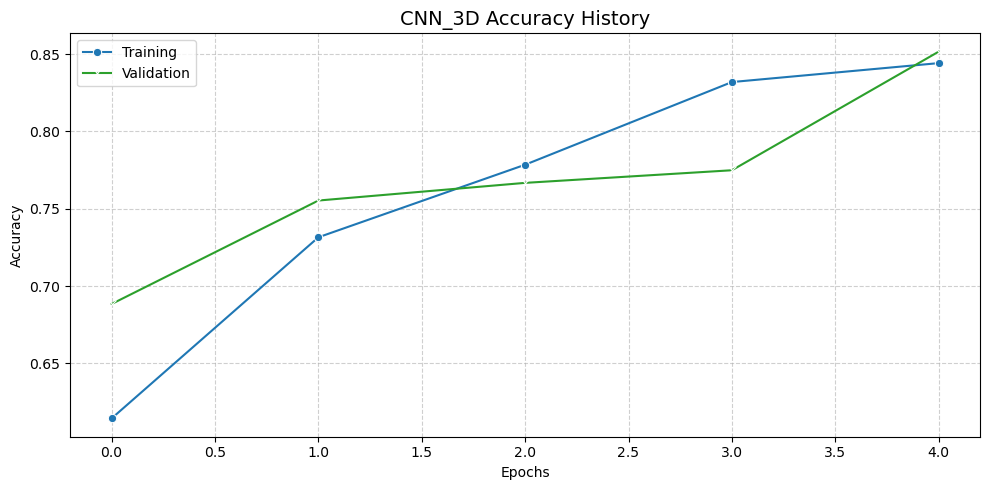

Train Accuracy = 0.8441452468866623; Validation Accuracy = 0.8515497553990288


In [6]:
cnn_trainer.plot_loss_history()
cnn_trainer.plot_accuracy()
train_accuracy = cnn_trainer.train_accuracy_history[-1]
validation_accuracy = cnn_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

In [7]:
save_trained_model_weights(model_cnn, out_dir=os.path.join(model_path, "CNN_3D"))

Saved training plots to ../src/models/CNN_3D/trained_CNN_3D_final.pt


# Step 2: Test ResNet Pretrained Model

In [31]:
inp_size = (224, 224)

In [32]:
model_resnet = MyResNet(num_classes=num_classes)

resnet_optimizer_config = {"optimizer_type": "adam", "lr": 1e-4, "weight_decay": 1e-8} # Tune these
resnet_optimizer = get_optimizer(model_resnet, resnet_optimizer_config)

resnet_trainer = Trainer(
    data_dir=data_path,
    model=model_resnet,
    optimizer=resnet_optimizer,
    model_dir=os.path.join(model_path, "ResNet"),
    train_data_transforms=get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, [dataset_mean], [dataset_std]
    ),
    batch_size=batch_size,
    load_from_disk=False,
    cuda=torch.cuda.is_available(),
)

In [ ]:
%%time
resnet_trainer.run_training_loop(num_epochs=20)

Minibatch:1 Train Loss:0.0329 Val Loss: 0.0329 Train Accuracy: 0.4688 Validation Accuracy: 0.4688
Minibatch:2 Train Loss:0.0329 Val Loss: 0.0329 Train Accuracy: 0.5000 Validation Accuracy: 0.5000
Minibatch:3 Train Loss:0.0349 Val Loss: 0.0349 Train Accuracy: 0.4062 Validation Accuracy: 0.4062
Minibatch:4 Train Loss:0.0352 Val Loss: 0.0352 Train Accuracy: 0.5000 Validation Accuracy: 0.5000
Minibatch:5 Train Loss:0.0353 Val Loss: 0.0353 Train Accuracy: 0.1875 Validation Accuracy: 0.1875
Minibatch:6 Train Loss:0.0337 Val Loss: 0.0337 Train Accuracy: 0.4688 Validation Accuracy: 0.4688
Minibatch:7 Train Loss:0.0340 Val Loss: 0.0340 Train Accuracy: 0.3438 Validation Accuracy: 0.3438
Minibatch:8 Train Loss:0.0322 Val Loss: 0.0322 Train Accuracy: 0.4375 Validation Accuracy: 0.4375
Minibatch:9 Train Loss:0.0335 Val Loss: 0.0335 Train Accuracy: 0.4375 Validation Accuracy: 0.4375
Minibatch:10 Train Loss:0.0328 Val Loss: 0.0328 Train Accuracy: 0.4062 Validation Accuracy: 0.4062
Minibatch:11 Train 

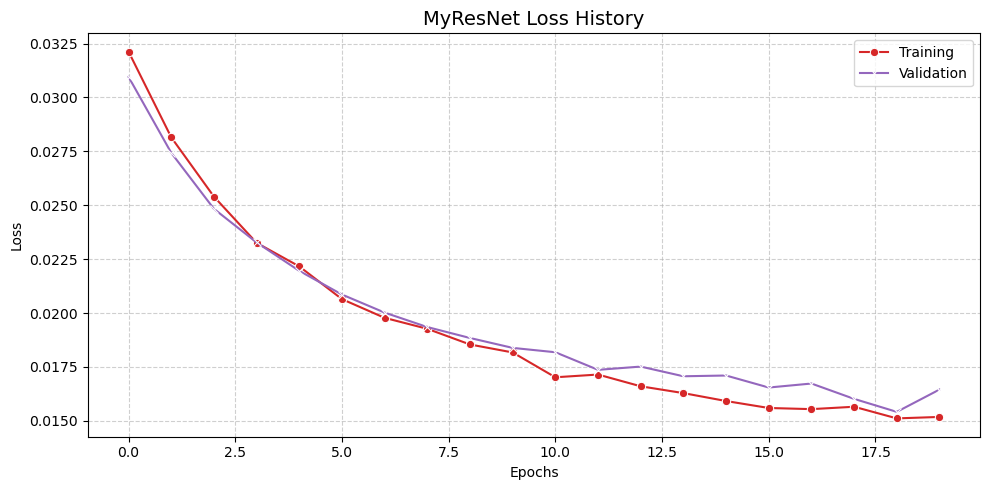

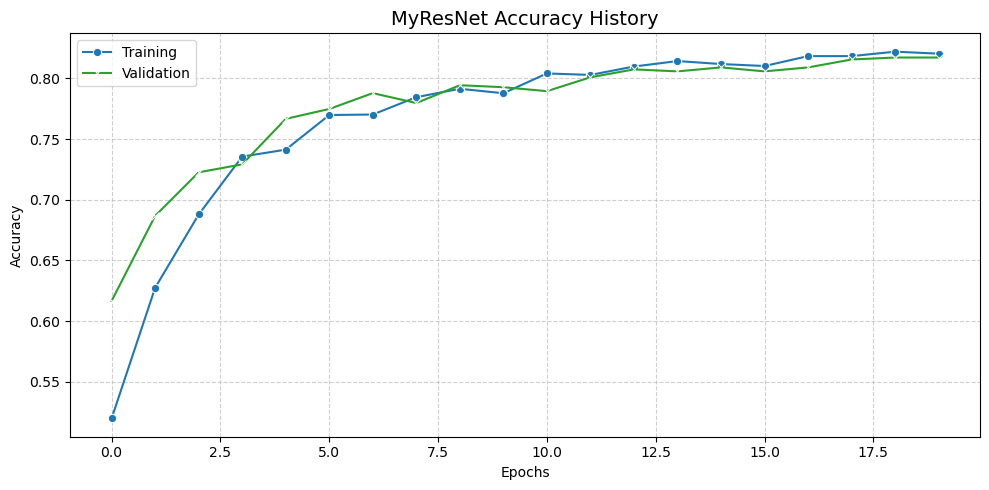

Train Accuracy = 0.8204814362457848; Validation Accuracy = 0.8172920067197541


In [ ]:
resnet_trainer.plot_loss_history()
resnet_trainer.plot_accuracy()
train_accuracy = resnet_trainer.train_accuracy_history[-1]
validation_accuracy = resnet_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

In [ ]:
save_trained_model_weights(model_resnet, out_dir=os.path.join(model_path, "ResNet"))

Saved training plots to ../src/models/ResNet/trained_MyResNet_final.pt


# Step 3: Test Inception Pretrained Model

In [15]:
inp_size = (299,299)

In [ ]:
model_inception = MyInception(num_classes=num_classes)

inception_optimizer_config = {"optimizer_type": "adam", "lr": 1e-5, "weight_decay": 1e-8} # Tune these
inception_optimizer = get_optimizer(model_inception, inception_optimizer_config)

inception_trainer = Trainer(
    data_dir=data_path,
    model=model_inception,
    optimizer=inception_optimizer,
    model_dir=os.path.join(model_path, "Inception"),
    train_data_transforms=get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, [dataset_mean], [dataset_std]
    ),
    batch_size=batch_size,
    load_from_disk=False,
    cuda=torch.cuda.is_available(),
)

In [ ]:
%%time
inception_trainer.run_training_loop(num_epochs=20)

Minibatch:1 Train Loss:0.0039 Val Loss: 0.0039 Train Accuracy: 0.9062 Validation Accuracy: 0.9062
Minibatch:2 Train Loss:0.0028 Val Loss: 0.0028 Train Accuracy: 1.0000 Validation Accuracy: 1.0000
Minibatch:3 Train Loss:0.0019 Val Loss: 0.0019 Train Accuracy: 1.0000 Validation Accuracy: 1.0000
Minibatch:4 Train Loss:0.0031 Val Loss: 0.0031 Train Accuracy: 0.9688 Validation Accuracy: 0.9688
Minibatch:5 Train Loss:0.0077 Val Loss: 0.0077 Train Accuracy: 0.9062 Validation Accuracy: 0.9062
Minibatch:6 Train Loss:0.0020 Val Loss: 0.0020 Train Accuracy: 0.9688 Validation Accuracy: 0.9688
Minibatch:7 Train Loss:0.0047 Val Loss: 0.0047 Train Accuracy: 0.9375 Validation Accuracy: 0.9375
Minibatch:8 Train Loss:0.0021 Val Loss: 0.0021 Train Accuracy: 1.0000 Validation Accuracy: 1.0000
Minibatch:9 Train Loss:0.0021 Val Loss: 0.0021 Train Accuracy: 1.0000 Validation Accuracy: 1.0000
Minibatch:10 Train Loss:0.0031 Val Loss: 0.0031 Train Accuracy: 0.9688 Validation Accuracy: 0.9688
Minibatch:11 Train 

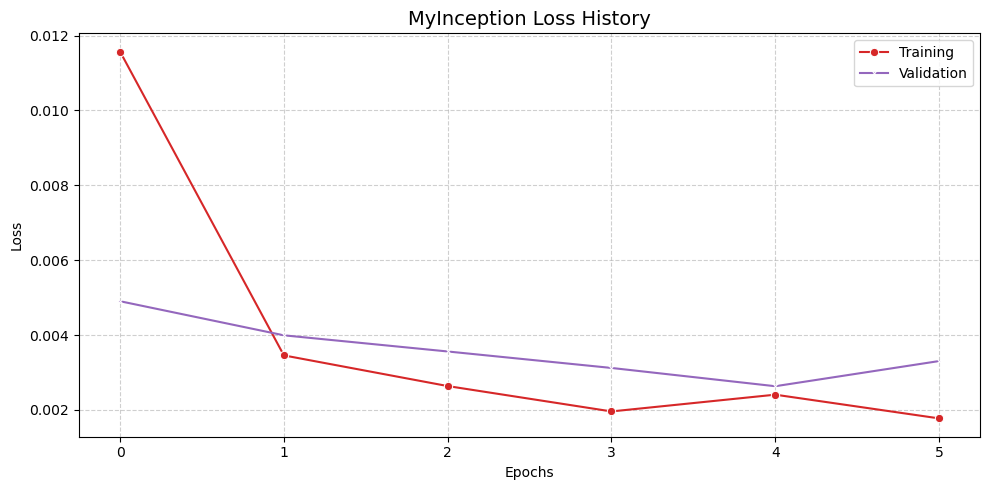

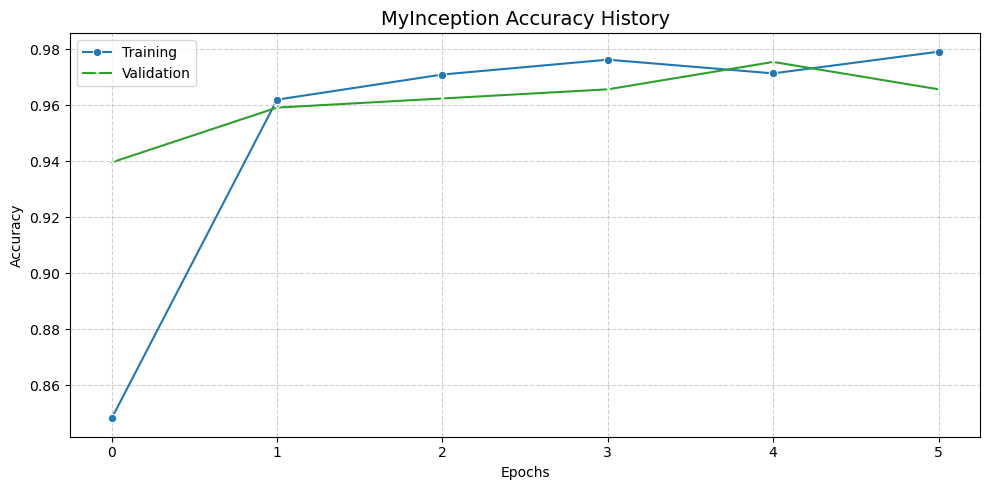

Train Accuracy = 0.9791921664626683; Validation Accuracy = 0.965742251223491


In [19]:
inception_trainer.plot_loss_history()
inception_trainer.plot_accuracy()
train_accuracy = inception_trainer.train_accuracy_history[-1]
validation_accuracy = inception_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

In [20]:
save_trained_model_weights(model_inception, out_dir=os.path.join(model_path, "Inception"))

Saved training plots to ../src/models/Inception/trained_MyInception_final.pt


# Step 4: Analyze Graphs and Final Accuracies

### Model Parameters

In [21]:
print('3D CNN:', model_cnn.count_parameters())
print('ResNet:', model_resnet.count_parameters())
print('Inception:', model_inception.count_parameters())

3D CNN: 1127063
ResNet: 11178051
Inception: 25124558


### Classification Results

In [22]:
cnn_trainer.print_classification_report()
resnet_trainer.print_classification_report()
inception_trainer.print_classification_report()

ValueError: Number of classes, 4, does not match size of target_names, 3. Try specifying the labels parameter

### Loss & Accuracy Graphs

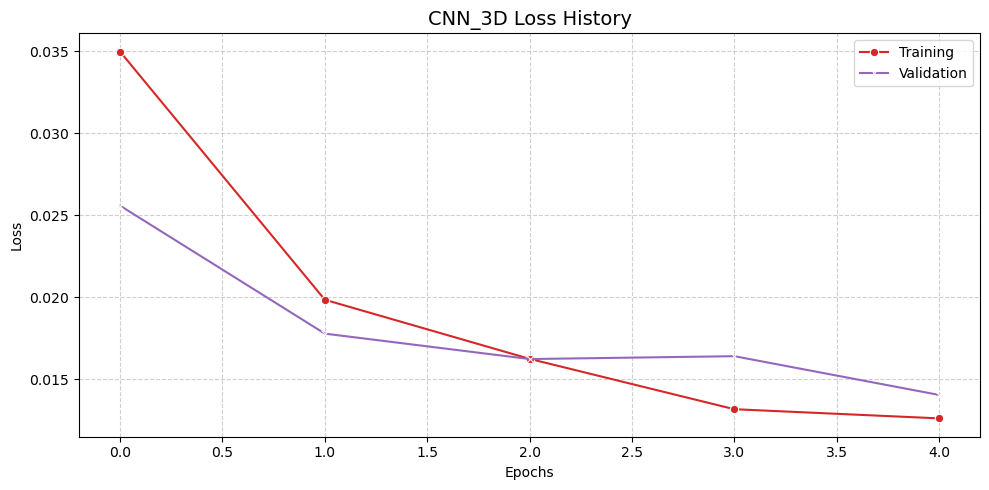

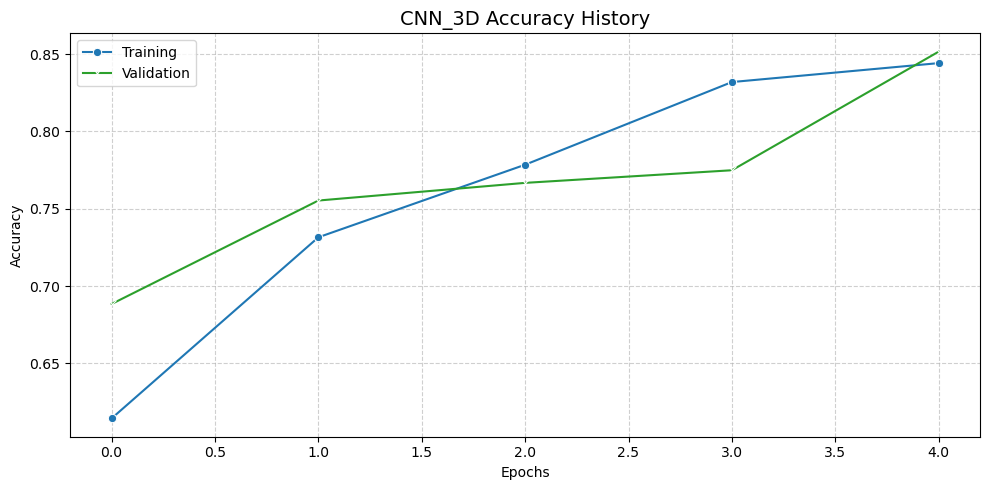

Train Accuracy = 0.8441452468866623; Validation Accuracy = 0.8515497553990288


In [23]:
cnn_trainer.plot_loss_history()
cnn_trainer.plot_accuracy()
train_accuracy = cnn_trainer.train_accuracy_history[-1]
validation_accuracy = cnn_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

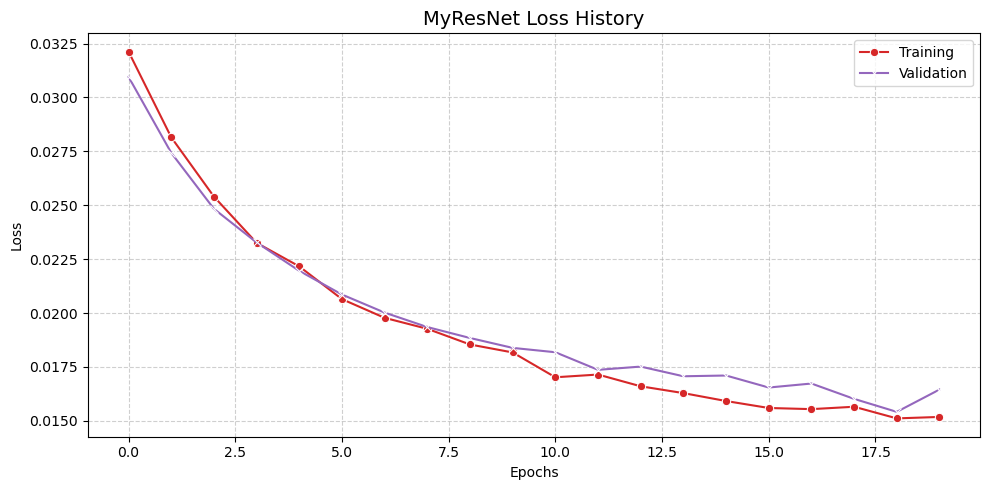

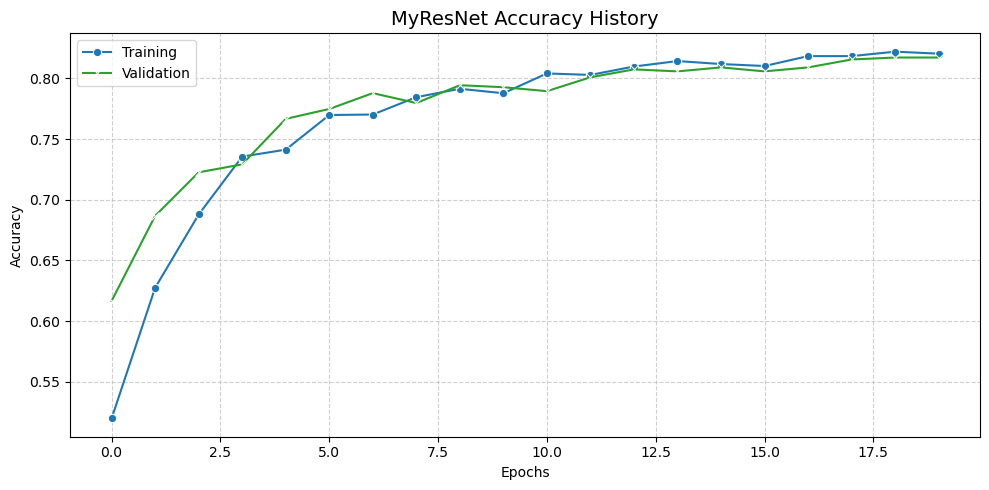

Train Accuracy = 0.8204814362457848; Validation Accuracy = 0.8172920067197541


In [24]:
resnet_trainer.plot_loss_history()
resnet_trainer.plot_accuracy()
train_accuracy = resnet_trainer.train_accuracy_history[-1]
validation_accuracy = resnet_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

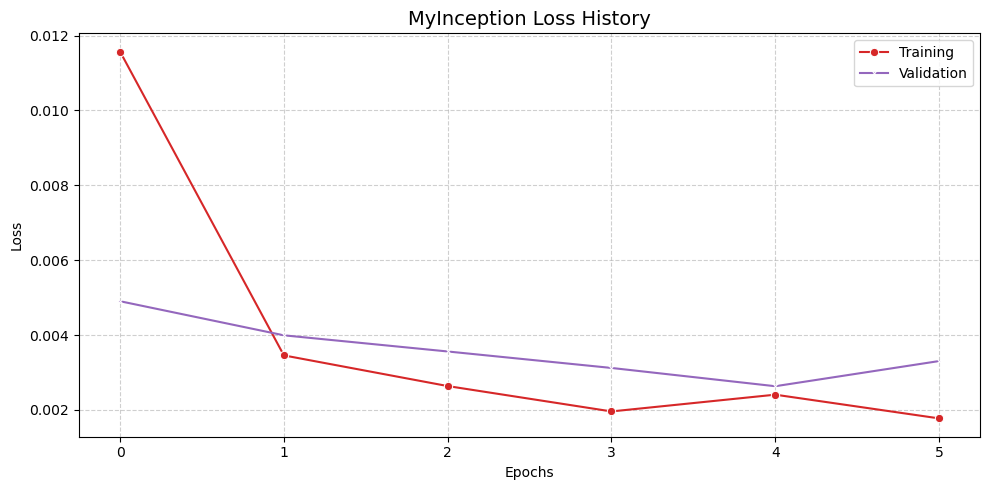

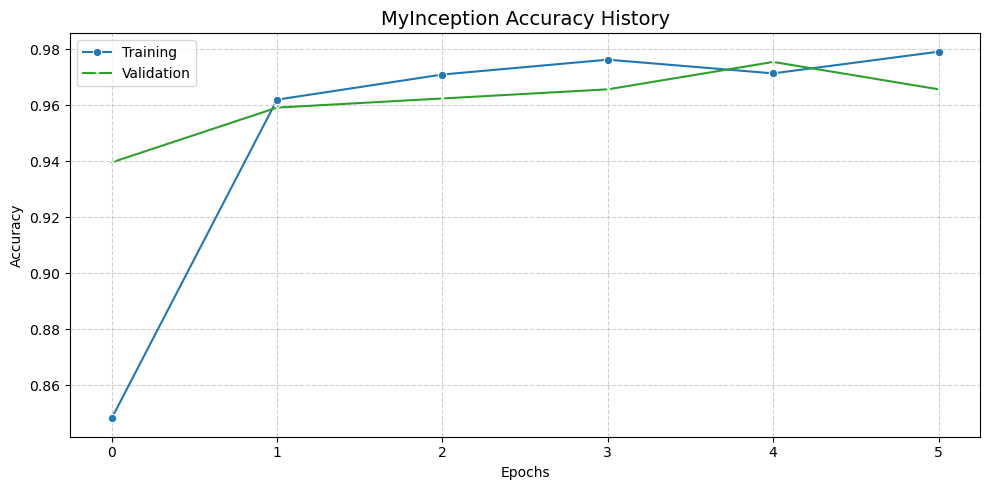

Train Accuracy = 0.9791921664626683; Validation Accuracy = 0.965742251223491


In [25]:
inception_trainer.plot_loss_history()
inception_trainer.plot_accuracy()
train_accuracy = inception_trainer.train_accuracy_history[-1]
validation_accuracy = inception_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

### Confusion Matrices

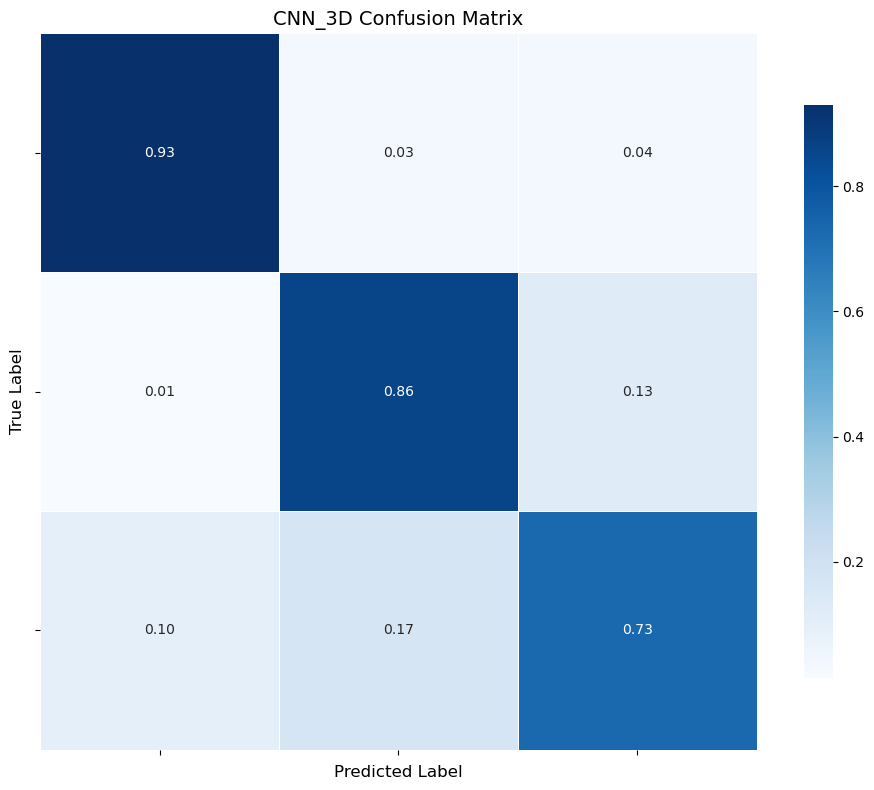

In [26]:
generate_and_plot_confusion_matrix(model_cnn, cnn_trainer.val_dataset, path=results_path, use_cuda=torch.cuda.is_available())

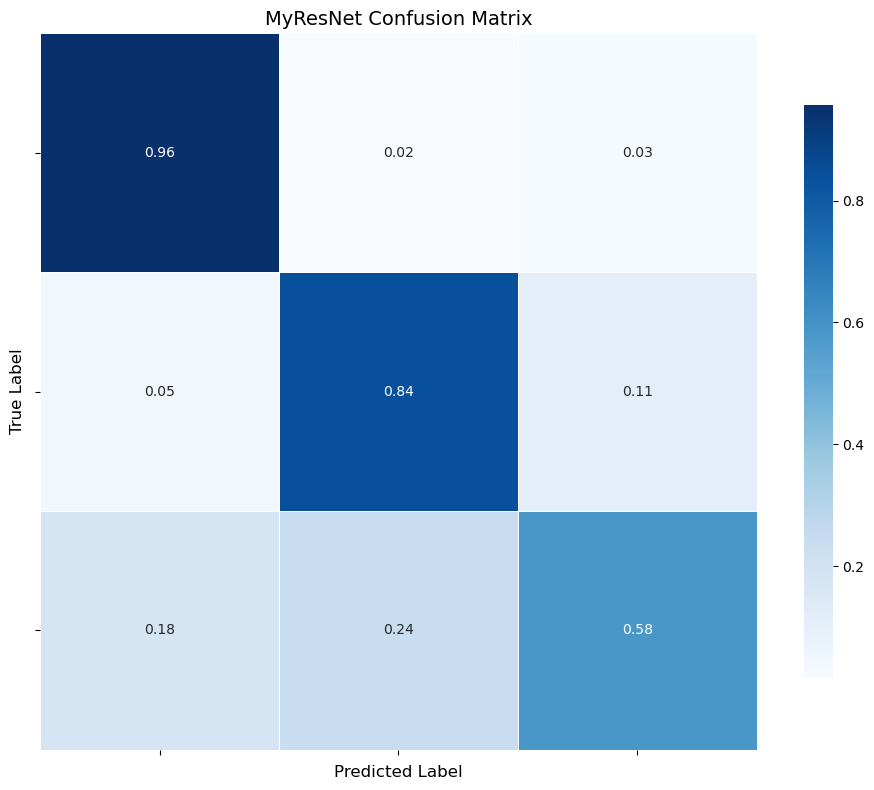

In [27]:
generate_and_plot_confusion_matrix(model_resnet, resnet_trainer.val_dataset, path=results_path, use_cuda=torch.cuda.is_available())

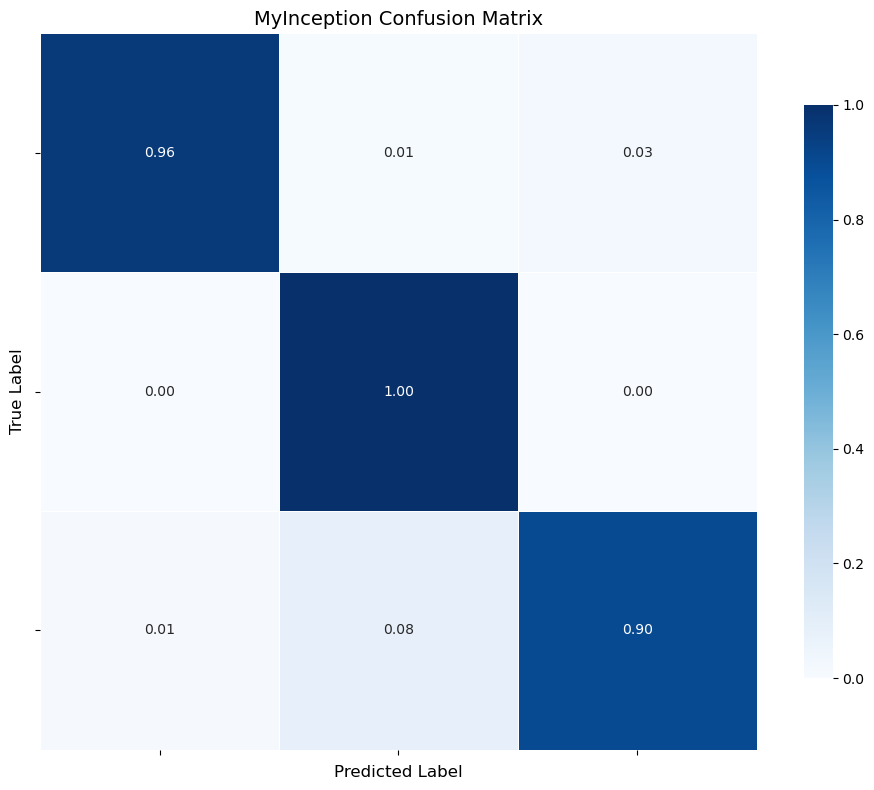

In [28]:
generate_and_plot_confusion_matrix(model_inception, inception_trainer.val_dataset, path=results_path, use_cuda=torch.cuda.is_available())

### Analyze errors that occurred from confusion matrix

{'Glioma': 0, 'Meningioma': 1, 'Pituitary': 2}


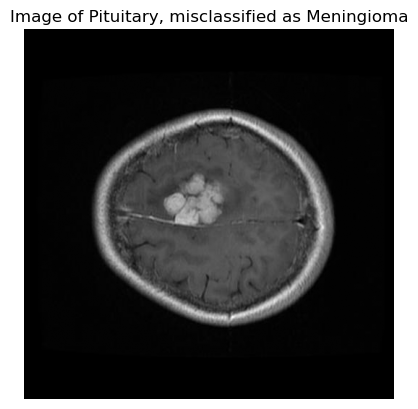

In [29]:
trainer = cnn_trainer # Change this
model = model_cnn # Change this

predicted_class_num = 1
true_class_num = 2
correct_class = [k for k, v in trainer.val_dataset.class_dict.items() if v == true_class_num][0]
pred_class = key = [k for k, v in trainer.val_dataset.class_dict.items() if v == predicted_class_num][0]
print(trainer.val_dataset.class_dict)

paths = get_pred_images_for_target(model, trainer.val_dataset, predicted_class_num, true_class_num, torch.cuda.is_available())
max_count = 1
count = 0
for path in paths:
    img = Image.open(path).convert(mode='L')
    if (count != max_count):
        plt.imshow(img, cmap='gray')
        plt.title(f'Image of {correct_class}, misclassified as {pred_class}')
        plt.axis('off')  # Removes axis ticks
        plt.savefig(os.path.join(results_path, f'{model.__class__.__name__}_misclassified.png')),
        plt.show()
        count += 1